# Package Load

In [29]:
import ipywidgets as widgets
import shutil
from ipywidgets import interact
from ipywidgets import interactive
import json
import gpt3 as gpt
from openai import OpenAIError
from IPython import display
from base64 import b64decode
from pprint import PrettyPrinter
import urllib.parse
import gromet as gromet
import requests
from datetime import datetime
import importlib
import matplotlib.pyplot as plt
import plotly.express as px
plt.style.use("fivethirtyeight")
import pandas as pd
import sys
import uuid
import os
import requests

# SKEMA TR pipeline
from typing import Any, List, Mapping, Optional
from pandas import DataFrame


# Demo Setup Parameters

In [30]:
XDD_GET_URL = "https://xdddev.chtc.io/askem/object/"
XDD_CREATE_URL = "https://xdddev.chtc.io/askem/create"
XDD_ARTICLES_URL = "https://xdd.wisc.edu/api/"
MIT_XDD_KEY = "81622ba9-b82d-4128-8eb3-bec123d03979"

ppr=PrettyPrinter()


#MODEL_BASE = "src.model"
DYNAMIC_MODEL_DIR = "dynmodels"
if not os.path.exists(DYNAMIC_MODEL_DIR):
    os.mkdir(DYNAMIC_MODEL_DIR)
DYNAMIC_MODEL_BASE = DYNAMIC_MODEL_DIR.replace("/", ".")

#originalModelModuleName = MODEL_BASE + "." + "CHIME_SIR_default_model"
#originalModelFileName = MODEL_BASE.replace(".", "/") + "/" + "CHIME_SIR_default_model" + ".py"


# Demo Functions

In [31]:
def storeModelSourceAndLoad(modelSrcTxt, askemMetadata):
    newModelFilename = str(uuid.uuid4())
    newModelFQFilename = DYNAMIC_MODEL_DIR + "/" + newModelFilename + ".py"
    newModelModuleName = DYNAMIC_MODEL_BASE + "." + newModelFilename

    with open(newModelFQFilename, "w") as fout:
        for line in modelSrcTxt:
            fout.write(line)
        fout.close()
    
    print("NEW MODULE NAME", newModelModuleName)
    newModule = importlib.import_module(newModelModuleName)
    newModule.__ASKEMMETADATA__ = askemMetadata
    return newModule


    

In [32]:
#
# This code will create a clone of the original model (called originalModelModuleName).
# It will mutate the new model s.t. if "constantLineNo" is >=0, it will replace oldConstant with newConstant
# Then it will return a newly-loaded module that reflects these changes, and which the code can invoke
#
def cloneAndMutateModel(inputModelModule, alterations):
    newModelFilename = str(uuid.uuid4())
    newModelFQFilename = DYNAMIC_MODEL_DIR + "/" + newModelFilename + ".py"
    newModelModuleName = DYNAMIC_MODEL_BASE + "." + newModelFilename
    
    alterationD = {}
    for constantLineNo, newConstant in alterations:
        alterationD[constantLineNo] = newConstant


    with open(inputModelModule.__file__, "r") as src:
        with open(newModelFQFilename, "w") as dst:
            for lineno, line in enumerate(src):
                if lineno in alterationD:
                    newConstant = alterationD[lineno]
                    lhs, rhs = line.split("=")
                    line = lhs + " = " + str(newConstant) + "\n"
                dst.write(line)

    newModelModule = importlib.import_module(newModelModuleName)

    #
    # MAKE CHANGES TO METADATA
    #
    newAskemMetadata = {}
    newAskemMetadata["ASKEM_ID"] = uuid.uuid4().hex
    newAskemMetadata["ASKEM_CLASS"] = "Thing"
    newAskemMetadata["PROPERTIES"] = [("Name", "Altered Model"),
                                    ("date", datetime.now().strftime("%b %d, %Y %H:%M:%S")),
                                     ("rawfile", newModelModule.__file__)]
    newAskemMetadata["EXTERNAL_URL"] = ""
    newAskemMetadata["DOMAIN_TAGS"] = ""
    newAskemMetadata["RAW_DATA"] = {"text": open(newModelModule.__file__).read()}
    
    newModelModule.__ASKEMMETADATA__ = newAskemMetadata
    return newModelModule


In [33]:
def visualizeChimeTypeModelOutputs(moduleToInvoke):
    modelMetadata = moduleToInvoke.__ASKEMMETADATA__
    askemId = modelMetadata["ASKEM_ID"]
    askemProperties = modelMetadata["PROPERTIES"]
    pDict = {}
    for k, v in askemProperties:
        pDict[k] = v
    
    d_a, s_a, i_a, r_a, e_a = moduleToInvoke.main()
    modelResults = {"susceptible": s_a,
             "infected": i_a,
             "recovered": r_a,
             "day": d_a,
             "ever_infected": e_a}
    df = pd.DataFrame(modelResults)
    df['day'] = df.index

    fig = px.line(df, 
                  x="day", 
                  y=["susceptible", "infected", "recovered"], 
                  color_discrete_sequence=["black", "red", "green"],
                  title="Model '" + pDict["Name"] + "' (ASKEM_ID:" + askemId + ", date:" + pDict["date"] + ")")
    fig.update_layout(yaxis_title="Population")
    fig.update_layout(xaxis_title="Day")
    return fig


In [34]:
def loadModelSourceFromXDD(xddid):
    r = requests.get(XDD_GET_URL + xddid)
    if r.status_code == 200:
        robj = r.json()
        if "success" in robj:
            successObj = robj["success"]
            xddObj = successObj["data"][0]

            dataObj = xddObj["data"]
            metadataObj = xddObj["metadata"]
            return dataObj
        else:
            raise Exception("Field 'success' not found in XDD fetched object" + robj)
    else:
        raise Exception("XDD GET failed")


In [35]:
def computeGrometRepr(lmodule):
    cast = gromet.run_python_to_cast(lmodule.__file__)
    gromet_object = gromet.run_cast_to_gromet_pipeline(cast)
    return gromet_object


In [36]:
def storeGrometInXDD(grometObj, srcModule):
    gromet_collection_dict = grometObj.to_dict()
    grometJsonRepr = gromet.dictionary_to_gromet_json(gromet.del_nulls(gromet_collection_dict))
    
    xddObj = {
        "metadata": "Blank Metadata Maybe Obsolete",
        "data": {
            "ASKEM_ID": uuid.uuid4().hex,
            "ASKEM_CLASS": "Thing",
            "PROPERTIES": [("Name", "Gromet representation of " + srcModule.__ASKEMMETADATA__["ASKEM_ID"]),
                         ("date", datetime.now().strftime("%b %d, %Y %H:%M:%S"))],
              "DOMAIN_TAGS": [],
              "RAW_DATA": grometJsonRepr,
              "EXTERNAL_URL": ""   
        }
    }
    r = requests.post(XDD_CREATE_URL,
                  headers={"x-api-key": MIT_XDD_KEY,
                          "Content-Type": "application/json"},
                      data=json.dumps(xddObj))  
    if r.status_code == 200:
        return r.json()["success"]["data"]["success"]["registered_ids"][0]
    else:
        raise Exception("Cannot PUT Gromet Object")



In [37]:
def storeAlteredModelInXDD(curModelModule):
    askemObj = curModelModule.__ASKEMMETADATA__
    xddObj = {
        "metadata": "Blank Metadata Maybe Obsolete",
        "data": askemObj
    }
    r = requests.post(XDD_CREATE_URL,
                    headers={"x-api-key": MIT_XDD_KEY,
                          "Content-Type": "application/json"},
                      data=json.dumps(xddObj))  
    if r.status_code == 200:
        return r.json()["success"]["data"]["success"]["registered_ids"][0]
    else:
        raise Exception("Cannot PUT altered model")


## SKEMA Text Reading Functions

In [38]:
def get_sentence(mention:Mapping[str, Any], documents:Mapping[str, Any]):
    """ Returns the text containing the mention """
    doc_id = mention['document']
    sentence_ix = mention['sentence']
    sentence = documents[doc_id]['sentences'][sentence_ix]
    return ' '.join(sentence['words'])


def build_groundings(mention:Mapping[str, Any]) -> Optional[str]:
    """ Extracts the grounding ID of the grounding associated to 
    the current mention """
    if mention['type'] == "TextBoundMention":
        groundings = list()
        for a in mention['attachments']:
            # If score is a field in the attachment, then this is a grounding
            if type(a) == list:
                for g in a[0]:
                    score = "{:.2f}".format(g['score'])
                    groundings.append(f"({g['name']}, {g['id']}, {score})")
        if len(groundings) > 0:
            return ', '.join(groundings)

In [39]:
def annotate_json(file_path:str, endpoint:str = "http://localhost:9000/cosmos_json_to_mentions") -> List[Mapping[str, Any]]:
    """ Annotates an existing json file on the server with the text reading pipeline """

    data = requests.post(endpoint, json={'pathToCosmosJson': file_path}).json()

    return data


def build_data_frame(mentions:List[Mapping[str, Any]], documents:Mapping[str, Any]) -> DataFrame:
    """ Builds a data frame from the output of text reading """

    return DataFrame(
        {
            'text': mention['text'],
            'sentence': get_sentence(mention, documents),
            'start_token': mention['tokenInterval']['start'],
            'end_token': mention['tokenInterval']['end'],
            'mention_type': mention['type'],
            'label': mention['labels'][0],
            'grounding_id': build_groundings(mention),
            # 'sentence_ix': mention['sentence'],
        }
        for mention in mentions
    )

def text_reading_mentions(file_path:str) -> DataFrame:
    """ Puts together annotation and creating the data frame"""
    return build_data_frame(**annotate_json(file_path))

In [40]:
def get_paper_by_doi(doi:str) -> Optional[str]:
    """ Mocks getting the Cosmos output by the paper's DOI """
    papers = {
        "10.1016/j.chaos.2021.110689": "/media/evo870/github/COSMOS-data/output_files/documents_5Febcovid19--COSMOS-data.json"
    }
    return papers.get(doi)

# TA-1 Demo Starts Here!

## Step 0: Indicate XDD identifier for input model source

In [41]:
modelSourceXDDId = "761ff74a-b0e1-48bf-b79a-851e3da6b207"


## Step 1: Import model source code from file, run it, and visualize results

In [42]:
askemObj = loadModelSourceFromXDD(modelSourceXDDId)
loadedModelModule = storeModelSourceAndLoad(askemObj["RAW_DATA"]["text"], askemObj)
visualizeChimeTypeModelOutputs(loadedModelModule)


NEW MODULE NAME dynmodels.2f86822e-0c23-743f-405b-ecf458edaff1


## Step 2: Analyze model source code to extract Gromet Function Network (SKEMA Code2FN), then insert Gromet result into XDD

A proof of concept has been created to show an in-application IDE in TERArium. This IDE is capable of running the custom VS code extension that we created to annotate code. In addtion, this extension enables the IDE in TERArium to send an entire source-code file to GROMET, receive the resulting GROMET, and highlight code syntax with relevant metadata so the end-user can confirm the GROMET extraction proceeded correctly.

Demo Video [TODO]

In [43]:

grometObject = computeGrometRepr(loadedModelModule)
grometXDDId = storeGrometInXDD(grometObject, loadedModelModule)
grometXDDId



'3d7f47f3-b96a-4745-8c55-6c11cf4f0ea9'

## Step 3: Load MIRA Epidemiology Domain Ontology Graph

We first set up access to the MIRA Epidemiology Domain Knowledge Graph (DKG) web service.

In [44]:
MIRA_DKG_URL = 'http://34.230.33.149:8771'

def get_mira_dkg_term(term, attribs):
    res = requests.get(MIRA_DKG_URL + '/api/search', params={'q': term})
    term = [entity for entity in res.json() if entity['id'].startswith('askemo')][0]
    res = {attrib: term.get(attrib) for attrib in attribs if term.get(attrib) is not None}
    return res

Next, we choose a set of terms and attributes to pull into a local ontology that we can use to connect to the model. In addition, for some of the terms, we define custom ranges in which their values for this model can be adjusted.

In [45]:
# Terms we want to find in MIRA and specific attributes we want to add to our local ontology
terms = ['population', 'doubling time', 'recovery time', 'infectious time']
attribs = ['description', 'synonyms', 'xrefs', 'suggested_unit', 'suggested_data_type',
           'physical_min', 'physical_max', 'typical_min', 'typical_max']

# The local ontology if filled up from the MIRA DKG
LOCAL_ONTOLOGY = {
    term: get_mira_dkg_term(term, attribs) for term in terms
    }

# We can also set further local / use-case specific constraints as needed
LOCAL_ONTOLOGY['population']['typical_min'] = 1000
LOCAL_ONTOLOGY['population']['typical_max'] = 40_000_000

LOCAL_ONTOLOGY

{'population': {'description': 'The number of people who live in an area being modeled.',
  'synonyms': [],
  'xrefs': [{'id': 'ido:0000509', 'type': 'skos:exactMatch'}],
  'suggested_unit': 'person',
  'suggested_data_type': 'int',
  'physical_min': 0.0,
  'typical_min': 1000,
  'typical_max': 40000000},
 'doubling time': {'description': 'The length of time that an infectious disease requires to double in incidence.',
  'synonyms': [{'value': 'doubling rate', 'type': 'skos:relatedMatch'}],
  'xrefs': [{'id': 'cemo:epidemic_doubling_time', 'type': 'skos:exactMatch'}],
  'suggested_unit': 'day',
  'suggested_data_type': 'float',
  'physical_min': 0.0},
 'recovery time': {'description': 'The length of time an infected individual needs to recover after being infected.',
  'synonyms': [{'value': 'mean recovery time', 'type': 'skos:exactMatch'},
   {'value': 'recovery rate', 'type': 'skos:relatedMatch'}],
  'xrefs': [],
  'suggested_unit': 'day',
  'suggested_data_type': 'float',
  'physica

## Step 4: Domain knowledge graph registration and indexing

xDD now has a framework to support ingestion of domain knowledge graphs stored in RDF format. Entities (nodes) from the MIRA knowledge graph have been stored as ASKEM objects (with class=Term), enabling recall within the xDD system:

In [46]:
url = f"{XDD_GET_URL}?askem_class=Term&description=incidence rate"
resp = requests.get(url)
data = resp.json()
result = data["success"]["data"][:3]
ppr.pprint(result)

[{'ASKEM_CLASS': 'Term',
  'ASKEM_ID': 'df8ac7ca-71f7-4a99-96fc-1225831ef7c1',
  '_xdd_created': '2022-10-05T20:28:55.095818',
  '_xdd_registrant': 4,
  'properties': {'description': 'Infectious disease incidence rate where the '
                                'infectious disease is COVID-19.',
                 'primaryName': 'COVID-19 incidence rate',
                 'source': 'https://askem-mira.s3.amazonaws.com/dkg/epi/build/2022-09-29/dkg.ttl.gz',
                 'sourceID': 'idocovid19:0001275',
                 'synonyms': ['']}},
 {'ASKEM_CLASS': 'Term',
  'ASKEM_ID': '585f7483-80f5-40ba-9589-b510a18a90de',
  '_xdd_created': '2022-10-05T20:27:57.178758',
  '_xdd_registrant': 4,
  'properties': {'description': 'An infectious disease incidence rate that is '
                                'typical for an infectious disease in an '
                                'organism population. ',
                 'primaryName': 'infectious disease endemic rate',
                 'source

This knowledge graph is then indexed and projected into the literature -- currently via a naive term-based matching. This enables summarization of label volume across the xDD corpus (or subsets therein). The example below looks at the hyper-focused modeling-specific subset (more info in the next step), accumulating the number of mentions within the literature of each node label within the ingested DKG.

In [47]:
url = f"{XDD_ARTICLES_URL}articles?dataset=askem_covid_demo&known_terms=mira_rdf_terms&term_format=full&n_hits=5"
resp = requests.get(url)
data = resp.json()
from collections import defaultdict
term_stats = defaultdict(int)
for document in data["success"]["data"]:
  for dictionary in document['known_terms']:
    for _, terms in dictionary.items():
      for term in terms:
        term_stats[term['term']] += term['n_hits']
ppr.pprint(sorted(term_stats.items(), key=lambda i: -i[1]))

[('COVID-19', 1254),
 ('time', 742),
 ('population', 725),
 ('disease', 707),
 ('infection', 577),
 ('All', 414),
 ('reproduction', 302),
 ('death', 146),
 ('effective', 138),
 ('system', 136),
 ('cell', 134),
 ('age', 128),
 ('Class', 113),
 ('is about', 109),
 ('vaccine', 103),
 ('is active in', 100),
 ('Severe', 97),
 ('date', 84),
 ('group', 83),
 ('Date', 82),
 ('consider', 78),
 ('function', 77),
 ('function of', 77),
 ('vaccination', 65),
 ('license', 64),
 ('vaccinated', 61),
 ('effectiveness', 59),
 ('process', 57),
 ('A2', 57),
 ('face', 57),
 ('prediction', 55),
 ('E2', 55),
 ('country', 53),
 ('antiviral', 53),
 ('report', 53),
 ('structure', 49),
 ('production', 49),
 ('lung', 49),
 ('E1', 49),
 ('duration', 47),
 ('Restriction', 46),
 ('incubation period', 41),
 ('USA', 40),
 ('Mild', 38),
 ('infected population', 36),
 ('infectious disease', 33),
 ('Frequency', 33),
 ('frequency', 33),
 ('dead', 32),
 ('algorithm', 31),
 ('id', 31),
 ('Source', 30),
 ('immune response', 

## Step 5: Literature queries and Relevant Corpus Definitions

xDD provides the ability to define _sets_ of documents to process and investigate as a small, targeted corpus. This enables users to reach into the relevant literature to extract text, tables, figures relevant to a query. Embedding models can be trained to enable phrase and document similarity lookups within this targeted set.

Two xDD sets have been defined for this demonstration: One very small, hyper-targeted set (33 documents), compiled through collaboration with Ben Gyori and the MITRE starter kit. The second casts a wider net (~9,000 documents), requiring occurrence of both "covid-19" (or a synonym) and one of a handful of modeling-related terms ["infection rate", "susceptible population", "recovery rate", ...]

### Similar documents
Given a DOI of a document ("Projections and fractional dynamics of COVID-19 with optimal control strategies" by Nabi et. al), we can quicky recovery semantically similar documents within the covid-19 modeling set:


In [48]:
url = f"https://xdd.wisc.edu/sets/xdd-covid-19-modeling/doc2vec/similar?doi=10.1016/j.chaos.2021.110689"
resp = requests.get(url)
ppr.pprint([f'{i["bibjson"]["title"]} ({i["bibjson"]["identifier"][0]["id"]})'  for i in resp.json()['data']])

['Investigation of nonlinear epidemiological models for analyzing and '
 'controlling the MERS outbreak in Korea (10.1016/j.jtbi.2017.10.004)',
 'Dynamics of a model with quarantine-adjusted incidence and quarantine of '
 'susceptible individuals (10.1016/j.jmaa.2012.10.015)',
 'Qualitative study of a quarantine/isolation model with multiple disease '
 'stages (10.1016/j.amc.2011.07.007)',
 'Optimal and sub-optimal quarantine and isolation control in SARS epidemics '
 '(10.1016/j.mcm.2007.04.003)',
 'Forecasting versus projection models in epidemiology: The case of the SARS '
 'epidemics (10.1016/j.mehy.2004.09.029)',
 'Mathematical modeling of COVID-19 epidemic with effect of awareness programs '
 '(10.1016/j.idm.2021.01.012)',
 'The dynamics of COVID-19 with quarantined and isolation '
 '(10.1186/s13662-020-02882-9)',
 'Modeling the transmission dynamics of the Middle East Respiratory Syndrome '
 'Coronavirus (MERS-CoV) with latent immigrants '
 '(10.1080/09720502.2019.1692429)',
 'D

### Parameter exploration

xDD allows the ability to search for text mentions of entities and parameters and, via COSMOS extractions, mentions within tables, figures, captions, and linked mentions within body text.

If a modeler is interested in finding more information about γ (recovery rate). They could look up usage of this parameter within related literature. For example, by explicitly looking it up within the SEIRS publication ("The SEIRS model for infectious disease dynamics"):


In [49]:
url = "https://xdd.wisc.edu/api/articles?title=" + urllib.parse.quote("The SEIRS model for infectious disease dynamics")
# https://xdd.wisc.edu/api/articles?title=The SEIRS model for infectious disease dynamics
resp = requests.get(url)
docid = resp.json()['success']['data'][0]["_gddid"]
url = "https://xdd.wisc.edu/api/snippets?term=" + urllib.parse.quote("γ") + f"&docid={docid}&clean"
# https://xdd.wisc.edu/api/snippets?term=γ&docid=616aca9567467f7269c432ba&clean
resp = requests.get(url)
ppr.pprint(resp.json())

{'success': {'data': [{'URL': 'http://www.nature.com/articles/s41592-020-0856-2',
                       '_gddid': '616aca9567467f7269c432ba',
                       'authors': 'Bjørnstad, Ottar N.; Shea, Katriona; '
                                  'Krzywinski, Martin; Altman, Naomi',
                       'coverDate': '2020 06',
                       'doi': '10.1038/s41592-020-0856-2',
                       'highlight': [' by the infectious  period 1/γ, the '
                                     'basic reproduction number  eRa0c',
                                     '), γ (recovery), ω (loss of immunity), α '
                                     '(infection-induced death) and µ (birth '
                                     'and background death',
                                     ' equilibrium values for R0 = 3, 1/γ = 14 '
                                     'days, 1/σ = 7 days, 1/ω = 1 year, 1/µ = '
                                     '76 years, α = 0 and β',
             

Indicating that a recovery time of 1/γ = 14 days may be a reasonable starting point. However, the user can cast a wider net, and seek tables of relevant values from the very-focused modeling literature:

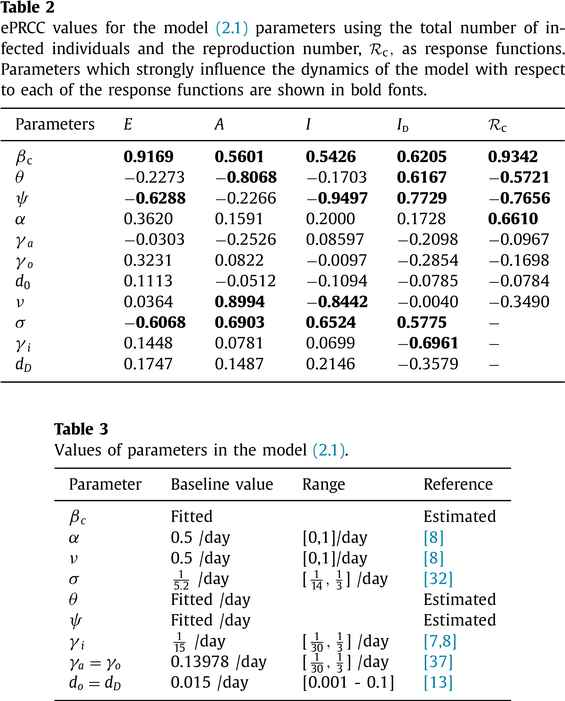

In [50]:
url = f"{XDD_GET_URL}?askem_class=Table&contentText=" + urllib.parse.quote("γ")
# https://xdddev.chtc.io/askem/object?askem_class=Table&contentText=γ

resp = requests.get(url)
data = resp.json()
result = data["success"]["data"][2] # Grab the element we want
# alternatively, direct URL: https://xdddev.chtc.io/askem/object/0842faf6-c659-4604-b553-55d8bfbe928d"
display.Image(b64decode(result['properties']['image']))

Part of this response is a dataframe extraction of the discovered table, which may be useful for extraction (or ingestion into the workbench via the dataset cleanup/annotation process under development by Jataware:

In [51]:
df = pd.read_json(json.dumps(result['properties']['contentJSON']))
df

,0,1,2
0,Table 2,,
1,,ePRCC values for the model (2.1) parameters using the total number of in-,
2,,"fected individuals and the reproduction number, R c , as response functions.",
3,,Parameters which strongly inﬂuence the dynamics of the model with respect,
4,to each of the response functions are shown in bold fonts.,,
5,Parameters \nE \nA,I \nI d,R c
6,β c \n0.9169 \n0.5601,0.5426 \n0.6205,0.9342
7,θ\n−0.2273 \n−0.8068,−0.1703 \n0.6167,−0.5721
8,ψ \n−0.6288 \n−0.2266,−0.9497 \n0.7729,−0.7656
9,α\n0.3620 \n0.1591,0.2000 \n0.1728,0.6610


## Step 6: [TODO] Possible Jataware table cleanup

A table reading proof of concept has been integrated into the Dojo data annotation stack. This demo shows the capability to place an image of a table and an editable copy of the extracted table into the dojo data registration flow. The end user can make changes to the table and then export it back to xDD.

Demo Video [TODO]

## Step 7: Perform machine reading of target paper (SKEMA Text Reading Pipeline), Grounding to concepts in the MIRA Epidemiology DKG

In [52]:
pd.set_option('display.max_colwidth', None)

paper_path = get_paper_by_doi("10.1016/j.chaos.2021.110689")

text_reading_mentions(paper_path)

ConnectionError: HTTPConnectionPool(host='localhost', port=9000): Max retries exceeded with url: /cosmos_json_to_mentions (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fccd613b940>: Failed to establish a new connection: [Errno 111] Connection refused'))

## Step 8: Analyze Gromet FN model role analysis (SKEMA MORAE Module)

[WIP]

SKEMA Model Role Analysis and Extraction Module analyzes FN to identify modeling roles. Adapts the Data Science Ontology framework.

![code_role](images/dso_goal_example.png)

![core_dynamics](images/flat_CHIME_sir_label.png)

## Step 9: Analyze alignment of documentation equations to Gromet FN (SKEMA ISA Module)

[WIP]

SKEMA Eqn2MathML module extracts MathML from documentation images of equations; represent MathML as graph structure; perform search to align structure equation and FN structure using 

![sgm_adj_marices](images/adjacent_matrices.png)

## Step 10: Analyze Gromet FN to identify beta parameter ranges that satisfy constraint (SKEMA FUNMAN)

## Step 11: Analyze Gromet representation to find connections between Gromet code and Pandemic Ontology's parameters ("knobs") (MIT System)

In [53]:
#
# Build Code/Ontology connections based on OpenAI GPT-3
#
# Hard coded version for connection

# targets = ['population', 'doubling time', 'recovery time', 'infectious time']


code = "CHIME_SIR_default_model.py"
terms = ['population', 'doubling time', 'recovery time', 'infectious time']
targets = ['population', 'infectious time']
discoveredParameterConnections = []
try:
    discoveredParameterConnections = gpt.match_targets(targets, code, terms)
except OpenAIError as err:
    print("OpenAI connection error:", err)
    print("Using hard-coded connections")
    discoveredParameterConnections = [("infectious time", {"name": "grometSubObject"}, 14.0, 67),("population", {"name": "grometSubObject"}, 1000, 80)]

discoveredParameterConnections

[('population', {'s_n': 'grometSubObject'}, 1000.0, 81),
 ('infectious time', {'infections_days': 'grometSubObject'}, 14.0, 68)]

## Step 12: Show the user the knobs we found in the code. User can adjust them and recompute

In [54]:
currentKnobs = {}
sliders = {}
rows = []
rows.append(widgets.HTML("<b>Recovered parameters</b>"))
for dpc in discoveredParameterConnections:
    parameterName, grometObj, curValue, lineOfCode = dpc
    ontologyRecord = LOCAL_ONTOLOGY[parameterName]  # ["parameters"][parameterName]

    currentKnobs[parameterName] = curValue
    curSlider = widgets.IntSlider(min=ontologyRecord["typical_min"], 
                                     max=ontologyRecord["typical_max"], 
                                     value=curValue)

    sliders[parameterName] = curSlider
    
    row = widgets.HBox([widgets.HTML(value="<b>" + parameterName + "</b>"), curSlider])
    tinyCell = widgets.VBox([row, widgets.Label(value=ontologyRecord["description"] + " (observed value: " + str(curValue) + ")")])
    rows.append(tinyCell)

button = widgets.Button(description="Alter Model")
output = widgets.Output()

newModelModules = []

def on_button_clicked(b):
    # rebuild the model and get the result
    edits = []
    for dpc in discoveredParameterConnections:
        parameterName, grometObj, curValue, lineOfCode = dpc
        sliderValue = sliders[parameterName].value
        edits.append((lineOfCode, sliderValue))

    newModelModule = cloneAndMutateModel(loadedModelModule, edits)
    with output:
        output.clear_output()
        newModelModules.clear()
        newModelModules.append(newModelModule)
        display(visualizeChimeTypeModelOutputs(newModelModule))
            
button.on_click(on_button_clicked)

rows.append(button)
rows.append(output)
for s in rows:
    display(s)

TypeError: 'module' object is not callable

## Step 13: Update beta analysis to show difference based on model reparameterization (SKEMA FUNMAN)

Generated updated BiLayer

## Step 14: When the user obtains an altered model she likes, she can choose to store it in XDD, along with metadata about how it was created

xDD has been extended to include rudimentary registration, recall, and searching of JSON objects. This registration is backed by a shared metadata schema, which serves as a sort of a data contract -- as long as the registered objects match the agreed upon schema, they will be indexed and queryable.

A primary benefit of xDD being the datastore is the potential benefit for synthesis and data integration within one system. The vision is to be able to bring back document, parameter, table, and structured datasets relevant to a query in one shot, rather than having to access multiple endpoints across the ecosystem.

A secondary benefit is having a central place to assign stable object identities that can be used throughout the ASKEM ecosystem, with one place for recalling the object.

The current status is that it is a viable proof of concept, with initial indexing on a handful of critical terms.

Short term improvement targets are updates to the recall API (more search options, pagination) and schema adherence checking.

Longer term development plans include a versioning system to track and return updates and annotations over time, while returning the latest version of an object by default.

In [ ]:
if len(newModelModules) > 0:
    print("XDD ID: ", storeAlteredModelInXDD(newModelModules[-1]))